## Create a Kubeflow Pipeline for BERT using Amazon SageMaker

**Run this Notebook from Sagemaker Notebook console**

### Install all necessary Libraries

In [ ]:
!pip install boto3
!pip install -q pip --upgrade
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0
!pip install -q transformers==2.8.0
!pip install -Uq tfx==0.21.4
!pip install -Uq tensorflow-text==2.1.1 
!pip install -Uq tensorflow-model-analysis==0.22.1
!pip install -Uq tensorflow-data-validation==0.22.0
!pip install -Uq tensorflow-transform==0.22.0
!pip install -Uq tensorflow_hub==0.8.0
!pip install -Uq tensorflow_datasets==3.2.1

## Install Kubeflow Pipelines SDK

In [ ]:
!pip install https://storage.googleapis.com/ml-pipeline/release/0.1.29/kfp.tar.gz --upgrade

In [ ]:
sess = boto3.Session()
account = boto3.client('sts').get_caller_identity().get('Account')
sm   = sess.client('sagemaker')
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=sess)

## Setup Environment Variables

In [9]:
import boto3

aws_region_as_slist=!curl -s http://169.254.169.254/latest/meta-data/placement/availability-zone | sed 's/\(.*\)[a-z]/\1/'
region = aws_region_as_slist.s
print('Region: {}'.format(region))

account_id=boto3.client('sts').get_caller_identity().get('Account')
print('Account ID: {}'.format(account_id))

bucket='sagemaker-{}-{}'.format(region, account_id)
print('S3 Bucket: {}'.format(bucket))

role='arn:aws:iam::{}:role/service-role/AmazonSageMaker-ExecutionRole-20200828T215329'.format(account_id)
print('SageMaker Role ARN: {}'.format(role))

Region: us-west-2
Account ID: 756917309578
S3 Bucket: sagemaker-us-west-2-756917309578
SageMaker Role ARN: arn:aws:iam::756917309578:role/service-role/AmazonSageMaker-ExecutionRole-20200828T215329


## Copy Data from Public S3 to Private S3

In [10]:
s3_public_path_tsv = 's3://amazon-reviews-pds/tsv'

In [ ]:
s3_private_path_tsv = 's3://{}/amazon-reviews-pds/tsv'.format(bucket)

!aws s3 cp --recursive $s3_public_path_tsv/ $s3_private_path_tsv/ --exclude "*" --include "amazon_reviews_us_Digital_Software_v1_00.tsv.gz"
!aws s3 cp --recursive $s3_public_path_tsv/ $s3_private_path_tsv/ --exclude "*" --include "amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz"
!aws s3 cp --recursive $s3_public_path_tsv/ $s3_private_path_tsv/ --exclude "*" --include "amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv.gz"

In [13]:
raw_input_data_s3_uri = 's3://{}/amazon-reviews-pds/tsv/'.format(bucket)

## Build Kubeflow Pipeline

In [14]:
import kfp
from kfp import components
from kfp import dsl
from kfp.aws import use_aws_secret

### We will Use already build pipeline 

In [15]:
sagemaker_process_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/3ebd075212e0a761b982880707ec497c36a99d80/components/aws/sagemaker/process/component.yaml')
sagemaker_train_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/3ebd075212e0a761b982880707ec497c36a99d80/components/aws/sagemaker/train/component.yaml')
sagemaker_model_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/3ebd075212e0a761b982880707ec497c36a99d80/components/aws/sagemaker/model/component.yaml')
sagemaker_deploy_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/3ebd075212e0a761b982880707ec497c36a99d80/components/aws/sagemaker/deploy/component.yaml')

## Setup Pre-Processing Code 

In [ ]:
processing_code_s3_uri = 's3://{}/processing_code/preprocess-scikit-text-to-bert.py'.format(bucket)
print(processing_code_s3_uri)

!aws s3 cp ./preprocess-scikit-text-to-bert.py $processing_code_s3_uri

In [1]:
!tar -cvzf sourcedir.tar.gz -C ./code .

In [2]:
!aws ecr create-repository --repository-name {ecr_repo_name}

In [22]:
training_code_s3_uri = 's3://{}/training_code/sourcedir.tar.gz'.format(bucket)
print(training_code_s3_uri)

!aws s3 cp sourcedir.tar.gz $training_code_s3_uri

s3://sagemaker-us-west-2-756917309578/training_code/sourcedir.tar.gz
upload: ./sourcedir.tar.gz to s3://sagemaker-us-west-2-756917309578/training_code/sourcedir.tar.gz


In [23]:
def processing_input(input_name, s3_uri, local_path, s3_data_distribution_type):
    return {
        "InputName": input_name,
        "S3Input": {
            "LocalPath": local_path,
            "S3Uri": s3_uri,
            "S3DataType": "S3Prefix",
            "S3DataDistributionType": s3_data_distribution_type,
            "S3InputMode": "File",
        },
    }


def training_input(input_name, s3_uri, s3_data_distribution_type):
    return {
        "ChannelName": input_name,
        "DataSource": {
            "S3DataSource": {
                "S3Uri": s3_uri, 
                "S3DataType": "S3Prefix",
                "S3DataDistributionType": s3_data_distribution_type                
            }
        },
    }

def processing_output(output_name, s3_uri, local_path, s3_upload_mode):
    return {
        "OutputName": output_name,
        "S3Output": {
            "LocalPath": local_path,            
            "S3Uri": s3_uri,
            "S3UploadMode": s3_upload_mode
        },
    }

----------------------------------

## Setup Pipeline and Deploy the Kubeflow pipeline

In [32]:
@dsl.pipeline(
    name="BERT Pipeline",
    description="BERT Pipeline",
)
def bert_pipeline(role=role, 
                  bucket=bucket, 
                  region=region,
                  raw_input_data_s3_uri=raw_input_data_s3_uri):

    import time
    import json

    processing_image='763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-training:2.1.0-cpu-py36-ubuntu18.04'.format(region)

    train_image='763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-training:2.1.0-cpu-py36-ubuntu18.04'.format(region)        
    serve_image='763104351884.dkr.ecr.{}.amazonaws.com/tensorflow-inference:2.1.0-cpu'.format(region)

    pipeline_name = 'kubeflow-pipeline-sagemaker-{}'.format(int(time.time()))

    ########################
    # Creating new varibles
    ########################    
    
    max_seq_length=64
    train_split_percentage=0.90
    validation_split_percentage=0.05
    test_split_percentage=0.05
    balance_dataset=True

    processed_train_data_s3_uri = 's3://{}/{}/processing/output/bert-train'.format(bucket, pipeline_name)
    processed_validation_data_s3_uri = 's3://{}/{}/processing/output/bert-validation'.format(bucket, pipeline_name)
    processed_test_data_s3_uri = 's3://{}/{}/processing/output/bert-test'.format(bucket, pipeline_name)

    processing_instance_type = 'ml.c5.2xlarge'
    processing_instance_count = 2

    network_isolation=False

    process = sagemaker_process_op(
        role=role,
        region=region,
        image=processing_image,
        network_isolation=network_isolation,
        instance_type=processing_instance_type,
        instance_count=processing_instance_count,
        container_arguments=['--train-split-percentage', str(train_split_percentage),
                             '--validation-split-percentage', str(validation_split_percentage),
                             '--test-split-percentage', str(test_split_percentage),
                             '--max-seq-length', str(max_seq_length),
                             '--balance-dataset', str(balance_dataset)],
        container_entrypoint=[
            "python3",
            "/opt/ml/processing/input/code/preprocess-scikit-text-to-bert.py",
        ],
        input_config=[
            processing_input(
                input_name="raw_input",
                s3_uri="{}".format(raw_input_data_s3_uri),
                local_path="/opt/ml/processing/input/data/",
                s3_data_distribution_type="ShardedByS3Key"
            ),
            processing_input(
                input_name="code",
                s3_uri="{}".format(processing_code_s3_uri),
                local_path="/opt/ml/processing/input/code",
                s3_data_distribution_type="FullyReplicated"
            ),
        ],
        output_config=[
            processing_output(
                output_name="bert-train",
                s3_uri="{}".format(processed_train_data_s3_uri),
                local_path="/opt/ml/processing/output/bert/train",
                s3_upload_mode="EndOfJob"
            ),
            processing_output(
                output_name="bert-validation",
                s3_uri="{}".format(processed_validation_data_s3_uri),
                local_path="/opt/ml/processing/output/bert/validation",
                s3_upload_mode="EndOfJob"
            ),
            processing_output(
                output_name="bert-test",
                s3_uri="{}".format(processed_test_data_s3_uri),
                local_path="/opt/ml/processing/output/bert/test",
                s3_upload_mode="EndOfJob"
            ),
        ],
    )


    ########################
    # Train your Model
    ########################
    
    train_channels = [
        training_input(input_name="train", 
                       s3_uri=processed_train_data_s3_uri,
                       s3_data_distribution_type="ShardedByS3Key"
        ),
        training_input(input_name="validation", 
                       s3_uri=processed_validation_data_s3_uri,
                       s3_data_distribution_type="ShardedByS3Key"
        ),                       
        training_input(input_name="test", 
                       s3_uri=processed_test_data_s3_uri,
                       s3_data_distribution_type="ShardedByS3Key"
        )
    ]

    epochs=1
    learning_rate=0.00001
    epsilon=0.00000001
    train_batch_size=128
    validation_batch_size=128
    test_batch_size=128
    train_steps_per_epoch=100
    validation_steps=100
    test_steps=100
    train_volume_size=1024
    use_xla=True
    use_amp=True
    freeze_bert_layer=False
    enable_sagemaker_debugger=False
    enable_checkpointing=False
    enable_tensorboard=False
    input_mode='Pipe'
    run_validation=True
    run_test=True
    run_sample_predictions=True

    train_instance_type='ml.c5.2xlarge'   
    train_instance_count=1

    train_output_location = "s3://{}/{}/output".format(bucket, pipeline_name)
    
    hyperparameters={
        'epochs': '{}'.format(epochs),
        'learning_rate': '{}'.format(learning_rate),
        'epsilon': '{}'.format(epsilon),
        'train_batch_size': '{}'.format(train_batch_size),
        'validation_batch_size': '{}'.format(validation_batch_size),
        'test_batch_size': '{}'.format(test_batch_size),                                             
        'train_steps_per_epoch': '{}'.format(train_steps_per_epoch),
        'validation_steps': '{}'.format(validation_steps),
        'test_steps': '{}'.format(test_steps),
        'use_xla': '{}'.format(use_xla),
        'use_amp': '{}'.format(use_amp),                                             
        'max_seq_length': '{}'.format(max_seq_length),
        'freeze_bert_layer': '{}'.format(freeze_bert_layer),
        'enable_sagemaker_debugger': '{}'.format(enable_sagemaker_debugger),
        'enable_checkpointing': '{}'.format(enable_checkpointing),
        'enable_tensorboard': '{}'.format(enable_tensorboard),                                        
        'run_validation': '{}'.format(run_validation),
        'run_test': '{}'.format(run_test),
        'run_sample_predictions': '{}'.format(run_sample_predictions),
        'model_dir': '{}'.format(train_output_location),
        'sagemaker_program': 'tf_bert_reviews.py',
        'sagemaker_region': '{}'.format(region),
        'sagemaker_submit_directory': training_code_s3_uri
    }
    hyperparameters_json = json.dumps(hyperparameters)
   

    metrics_definitions = [
        {'Name': 'train:loss', 'Regex': 'loss: ([0-9\\.]+)'},
        {'Name': 'train:accuracy', 'Regex': 'accuracy: ([0-9\\.]+)'},
        {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9\\.]+)'},
        {'Name': 'validation:accuracy', 'Regex': 'val_accuracy: ([0-9\\.]+)'},
    ]
    metrics_definitions_json = json.dumps(metrics_definitions)
    print(metrics_definitions_json)

  
    training = sagemaker_train_op(
        region=region,
        image=train_image,
        network_isolation=network_isolation,        
        instance_type=train_instance_type,
        instance_count=train_instance_count,
        hyperparameters=hyperparameters_json,
        training_input_mode=input_mode,    
        channels=train_channels,        
        model_artifact_path=train_output_location,
        role=role        
    ).after(process)


    ########################
    # Deploy your model
    ########################
    
    create_model = sagemaker_model_op(
        region=region,
        model_name=training.outputs["job_name"],
        image=serve_image,
        model_artifact_url=training.outputs["model_artifact_url"],
        role=role
    )

    deploy_instance_type='ml.c5.2xlarge'
    deploy_instance_count=1

    deploy_model = sagemaker_deploy_op(
        region=region,
        model_name_1=create_model.output,
        instance_type_1=deploy_instance_type,
        initial_instance_count_1=deploy_instance_count        
    )

## Compile Kubeflow Pipeline

In [34]:
kfp.compiler.Compiler().compile(bert_pipeline, 'bertpipeline.zip')

[{"Name": "train:loss", "Regex": "loss: ([0-9\\.]+)"}, {"Name": "train:accuracy", "Regex": "accuracy: ([0-9\\.]+)"}, {"Name": "validation:loss", "Regex": "val_loss: ([0-9\\.]+)"}, {"Name": "validation:accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}]


In [ ]:
!ls -al ./bertpipeline.zip
!unzip -o ./bertpipeline.zip

In [37]:
!cat pipeline.yaml

apiVersion: argoproj.io/v1alpha1
kind: Workflow
metadata:
  annotations:
    pipelines.kubeflow.org/pipeline_spec: '{"description": "BERT Pipeline", "inputs":
      [{"default": "arn:aws:iam::756917309578:role/service-role/AmazonSageMaker-ExecutionRole-20200828T215329",
      "name": "role"}, {"default": "sagemaker-us-west-2-756917309578", "name": "bucket"},
      {"default": "us-west-2", "name": "region"}, {"default": "s3://sagemaker-us-west-2-756917309578/amazon-reviews-pds/tsv/",
      "name": "raw_input_data_s3_uri"}], "name": "BERT Pipeline"}'
  generateName: bert-pipeline-
spec:
  arguments:
    parameters:
    - name: role
      value: arn:aws:iam::756917309578:role/service-role/AmazonSageMaker-ExecutionRole-20200828T215329
    - name: bucket
      value: sagemaker-us-west-2-756917309578
    - name: region
      value: us-west-2
    - name: raw-input-data-s3-uri
      value: s3://sagemaker-us-west-2-756917309578/amazon-reviews-pds/tsv/
  entrypoint: bert-pipeline
  serviceAccoun

## Launch Kubeflow Pipeline on Kubernetes Cluster

In [39]:
client = kfp.Client()

aws_experiment = client.create_experiment(name='aws')

my_run = client.run_pipeline(aws_experiment.id, 
                             'bertpipeline', 
                             'bertpipeline.zip')

## Click on the above link or you can see the pipeline in Kubeflow dashboard

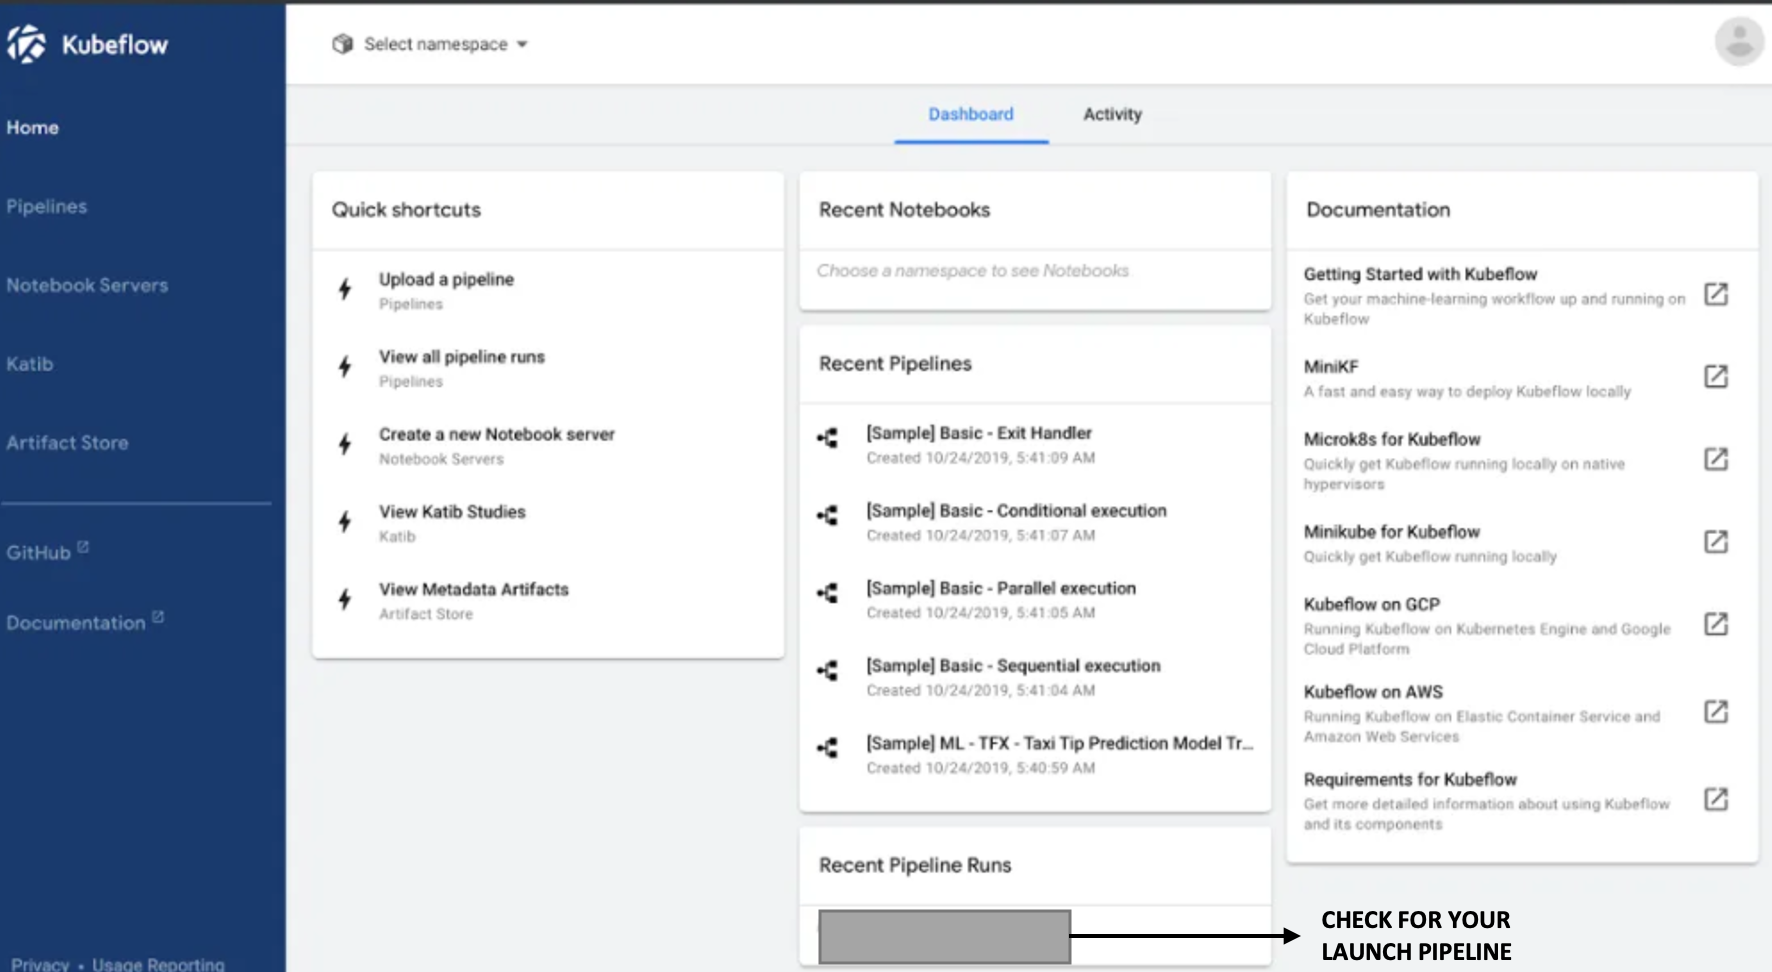